# Playground

## Wine classifier

In [2]:
from sklearn.datasets import load_wine

wine = load_wine()
df = pd.DataFrame(wine.data, columns=wine.feature_names)
df['wine'] = wine.target
df.head(5)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,wine
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


In [25]:
df['wine'].value_counts()

1    71
0    59
2    48
Name: wine, dtype: int64

In [26]:
colname = 'proline'
targetname='wine'

X = df.drop(targetname, axis=1)
y = df[targetname].astype(int)

rf = RandomForestRegressor(n_estimators=3,
                           min_samples_leaf=3,
                           oob_score=False)
rf.fit(X.drop(colname,axis=1), y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=3, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [27]:
ncats = len(np.unique(y))
nbins = 10
overall_range = (np.min(X[colname]), np.max(X[colname]))
#np.linspace(*overall_range, nbins)
from sklearn.preprocessing import KBinsDiscretizer
bin = KBinsDiscretizer(n_bins=nbins, strategy='uniform', encode='ordinal')
bin.fit(X[[colname]], y)

KBinsDiscretizer(encode='ordinal', n_bins=10, strategy='uniform')

In [28]:
leaves = leaf_samples(rf, X.drop(colname, axis=1))
samples = leaves[3]
one_leaf_samples = X.iloc[samples]
leaf_x = one_leaf_samples[colname].values
leaf_y = y.iloc[samples].values
Xy = pd.DataFrame(np.array([leaf_x,leaf_y]).T, columns=['xi','y'])
Xy.sort_values('xi')

,xi,y
2,392.0,1.0
0,450.0,1.0
1,510.0,1.0
3,580.0,2.0
5,640.0,2.0
4,830.0,2.0


In [29]:
binned_x = bin.transform(leaf_x.reshape(-1,1)).flatten().astype(int)
Xy['xi'] = binned_x
Xy.sort_values('xi').astype(int)

,xi,y
2,0,1
0,1,1
1,1,1
3,2,2
5,2,2
4,3,2


In [30]:
Xy.groupby('xi')['y'].apply(lambda x:x.values.astype(int))

xi
0       [1]
1    [1, 1]
2    [2, 2]
3       [2]
Name: y, dtype: object

In [31]:
"""
Get ncats-sized array for each xi bin with count of cat values; e.g., for xi->y and 3 cats
	xi	y
1	0	1
2	1	1
3	1	2
0	7	0

we get:

xi
0    [0, 1, 0]
1    [0, 1, 1]
7    [1, 0, 0]
"""
cats_per_bin = Xy.groupby('xi')['y'].apply(lambda x:np.bincount(x.values.astype(int), minlength=ncats))
cats_per_bin

xi
0    [0, 1, 0]
1    [0, 2, 0]
2    [0, 0, 2]
3    [0, 0, 1]
Name: y, dtype: object

In [32]:
cat_changes_per_bin = np.diff(cats_per_bin)
cat_changes_per_bin

array([array([0, 1, 0]), array([ 0, -2,  2]), array([ 0,  0, -1])],
      dtype=object)

In [33]:
cat_changes_per_bin = np.vstack(cat_changes_per_bin) # make into matrix (|xi|,ncats) not list of vectors
cat_changes_per_bin

array([[ 0,  1,  0],
       [ 0, -2,  2],
       [ 0,  0, -1]])

In [34]:
# get a 0-vector of size ncats as first row for first xi bin
# TODO: maybe should be nan indicating we don't know changes for first bin
# or maybe strip away first bin?
cat_changes_per_bin = np.vstack([np.full(ncats,np.nan), cat_changes_per_bin])
cat_changes_per_bin

array([[nan, nan, nan],
       [ 0.,  1.,  0.],
       [ 0., -2.,  2.],
       [ 0.,  0., -1.]])

In [35]:
Xy

,xi,y
0,1,1.0
1,1,1.0
2,0,1.0
3,2,2.0
4,3,2.0
5,2,2.0


In [36]:
np.array(sorted(binned_x)[1:])

array([1, 1, 2, 2, 3])

## Random stuff

In [ ]:
def collect_leaf_catcounts(X,y):
    catcol = y.astype('category').cat.as_ordered()
    cats = catcol.cat.categories

    leaves = leaf_samples(rf, X.drop(colname, axis=1))
    Xy = pd.concat([X, y], axis=1)
    ncats = len(np.unique(y))
    nleaves = len(leaves)

    leaf_yhistos = pd.DataFrame(index=cats)
    leaf_yhistos.index.name = 'category'

    leaf_xranges = np.zeros(shape=(nleaves, 2, ncats))
    
    leaf_xranges = []

    ci = 0
    for samples in leaves:
        leaf_obs = Xy.iloc[samples]
        ycounts = leaf_obs['wine'].value_counts()
        if len(ycounts) < 2:
#             print(f"ignoring len {len(ycounts)} ycats in leaf")
            continue
#         print(ycounts)
        r = (np.min(leaf_obs[colname]), np.max(leaf_obs[colname]))
        if np.isclose(r[0], r[1]):
            # print(f"ignoring xleft=xright @ {r[0]}")
            continue
#         leaf_xranges[ci,(0,1),0] = r
        leaf_xranges.append(r)
        relative_ycat_changes_for_leaf = ycounts - np.min(ycounts.values)
        leaf_yhistos['leaf' + str(ci)] = relative_ycat_changes_for_leaf
        ci += 1

    leaf_xranges = np.array(leaf_xranges)
    return leaf_xranges, leaf_yhistos

In [ ]:
leaf_xranges, leaf_yhistos = collect_leaf_catcounts(X,y)
leaf_yhistos.head()

In [ ]:
leaf_xranges

In [ ]:
def foo(leaf_xranges, leaf_yhistos):
    uniq_x = set(leaf_xranges[:, 0]).union(set(leaf_xranges[:, 1]))
    uniq_x = np.array(sorted(uniq_x))
    nx = len(uniq_x)
    ncats = len(np.unique(y))
    nleaves = len(leaf_xranges)

    allcounts = []
    ci = 0
    for cat in leaf_yhistos.index:
        counts = np.zeros(shape=(nx, nleaves))
        catcount_in_leaves = leaf_yhistos.loc[cat].values
        print()
        print(cat,'->',catcount_in_leaves)
        i = 0  # leaf index; we get a cat count for each leaf (and per category level)
        for r, catcount in zip(leaf_xranges,catcount_in_leaves):
            c = np.full(nx, catcount) # c has cat value at all x locations (flat line)
            c[np.where(uniq_x < r[0])] = np.nan # wipe out other areas
            c[np.where(uniq_x > r[1])] = np.nan
#             print(catcount)
            counts[:, i] = c
            i += 1
        
        print(counts)
        sum_at_x = np.nansum(counts, axis=1)
        missing_values_at_x = np.isnan(counts).sum(axis=1)
        count_at_x = nleaves - missing_values_at_x
        # The value could be genuinely zero so we use nan not 0 for out-of-range
        avg_count_at_x = sum_at_x / count_at_x
#         print(avg_count_at_x)
        allcounts.append(avg_count_at_x)

        ci += 1

    return uniq_x, np.array(allcounts)

In [ ]:
uniq_x, counts = foo(leaf_xranges, leaf_yhistos)

In [ ]:
counts

In [ ]:
uniq_x

In [ ]:
counts[:,0]

In [ ]:
fig, ax = plt.subplots(1, 1)

for ci in range(0,2+1):
    ax.bar(uniq_x, counts[ci], width=20, alpha=.3)
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1)

for ci in range(0,2+1):
    ax.bar(uniq_x, counts[ci], width=30, alpha=.3)
plt.show()

## Logistic regression

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

from sklearn.datasets import load_wine

wine = load_wine()
df = pd.DataFrame(wine.data, columns=wine.feature_names)
df['wine'] = wine.target
df.head(5)

In [ ]:
targetname='wine'
colname = 'proline'

X = df[[colname]]#df.drop(targetname, axis=1)
y = df[targetname]
lowregularization = 100
logr = LogisticRegression(C=lowregularization, multi_class='ovr')
logr.fit(X, y)
logr.predict(X)
logr.coef_.flatten(), logr.intercept_

In [ ]:
fig, ax = plt.subplots(1, 1)

def logodds2prob(x): return 1 / (1 + np.exp(x))

ax.scatter(X[colname].values, y, s=10, c='k')
# ax.scatter(X[colname].values, logr.predict(X[[colname]]), c='maroon', s=3)
y_ = logr.predict(X[[colname]])
coef = logr.coef_.flatten()
y1 = X[colname].values * coef[0] + logr.intercept_[0]
y2 = X[colname].values * coef[1] + logr.intercept_[1]
y3 = X[colname].values * coef[2] + logr.intercept_[2]
p1 = 1-logodds2prob(y1) # sklearn is treating the y values in weird way; needed to flip probabilities
p2 = 1-logodds2prob(y2)
p3 = 1-logodds2prob(y3)
ax.scatter(X[colname].values, p1, label='class1', s=3)
ax.scatter(X[colname].values, p2, label='class2', s=3)
ax.scatter(X[colname].values, p3, label='class3', s=3)

#print(y_)
odds = np.exp(y_).ravel()
#print(f"odds {odds}")
p = odds / (1 + odds)
#print(f"p {p}")
#ax.plot(X.values, sigmoid(y_), c='blue')
#ax.plot(X.values, (expit(lr.predict(X))), c='maroon')

ax.legend()
plt.show()

In [ ]:
def collect_leaf_slopes(rf, X, y, colname, hires_threshold, isclassifier=False):
    """
    For each leaf of each tree of the random forest rf (trained on all features
    except colname), get the samples then isolate the column of interest X values
    and the target y values. Perform a regression to get the slope of X[colname] vs y.
    We don't need to subtract the minimum y value before regressing because
    the slope won't be different. (We are ignoring the intercept of the regression line).

    Return for each leaf, the range of X[colname], y at left/right of leaf range,
    and associated slope for that range.

    Currently, leaf_yranges is unused.
    """
    start = time.time()
    nuniq_y = len(np.unique(y))
    leaf_slopes = []
    leaf_intercepts = []
    leaf_xranges = []
    leaf_yranges = []
    leaves = leaf_samples(rf, X.drop(colname, axis=1))
    for samples in leaves:
        one_leaf_samples = X.iloc[samples]
        leaf_x = one_leaf_samples[colname].values
        leaf_y = y.iloc[samples].values
        r = (np.min(leaf_x), np.max(leaf_x))
        if np.isclose(r[0], r[1]):
            # print(f"ignoring xleft=xright @ {r[0]}")
            continue
        if isclassifier:
            leaf_classes = np.unique(leaf_y)
            if len(leaf_classes)<2:
                continue
            lowregularization = 100
            logr = LogisticRegression(C=lowregularization, multi_class='ovr')
            logr.fit(leaf_x.reshape(-1, 1), leaf_y)
            allcoeff = np.full(nuniq_y, np.nan)
            allintercepts = np.full(nuniq_y, np.nan)
            coeff = logr.coef_.flatten()
            intercepts = logr.intercept_
            if len(coeff)==1:
                # To go from binary case which gives one coeff, negate beta and intercept to get other.
                coeff = np.array([coeff[0], -coeff[0]])
                intercepts = np.array([logr.intercept_[0], -logr.intercept_[0]])
            allcoeff[leaf_classes] = coeff # assumes classes are 0,1,2,...
            allintercepts[leaf_classes] = intercepts
#             print(leaf_classes, allcoeff, allintercepts)
            leaf_slopes.append(allcoeff)
            leaf_intercepts.append(allintercepts)
        else:
            lm = LinearRegression()
            lm.fit(leaf_x.reshape(-1, 1), leaf_y)
            leaf_slopes.append(lm.coef_[0])
            leaf_intercepts.append(lm.intercept_[0])
        leaf_xranges.append(r)
        leaf_yranges.append((leaf_y[0], leaf_y[-1]))
    leaf_slopes = np.array(leaf_slopes)
    leaf_intercepts = np.array(leaf_intercepts)
    leaf_xranges = np.array(leaf_xranges)
    leaf_yranges = np.array(leaf_yranges)
    stop = time.time()
    print(f"collect_leaf_slopes {stop - start:.3f}s")
    return leaf_xranges, leaf_yranges, leaf_slopes, leaf_intercepts

In [ ]:
def avg_slope_at_x(leaf_ranges, leaf_slopes):
    start = time.time()
    uniq_x = set(leaf_ranges[:, 0]).union(set(leaf_ranges[:, 1]))
    uniq_x = np.array(sorted(uniq_x))
    nx = len(uniq_x)
    nslopes = len(leaf_slopes)
    slopes = np.zeros(shape=(nx, nslopes))
    i = 0  # leaf index; we get a line for each leaf
    # collect the slope for each range (taken from a leaf) as collection of
    # flat lines across the same x range
    for r, slope in zip(leaf_ranges, leaf_slopes):
        s = np.full(nx, slope) # s has value scope at all locations (flat line)
        # now trim line so it's only valid in range r
        s[np.where(uniq_x < r[0])] = np.nan
        s[np.where(uniq_x > r[1])] = np.nan
        slopes[:, i] = s
        i += 1
    # Now average horiz across the matrix, averaging within each range
    sum_at_x = np.nansum(slopes, axis=1)
    missing_values_at_x = np.isnan(slopes).sum(axis=1)
    count_at_x = nslopes - missing_values_at_x
    # The value could be genuinely zero so we use nan not 0 for out-of-range
    avg_slope_at_x = sum_at_x / count_at_x

    stop = time.time()
    # print(f"avg_slope_at_x {stop - start:.3f}s")
    return uniq_x, avg_slope_at_x

In [ ]:
X = df.drop(targetname, axis=1)
y = df[targetname]
ntrees = 100
min_samples_leaf = 11
rf = RandomForestRegressor(n_estimators=ntrees,
                           min_samples_leaf=min_samples_leaf,
                           oob_score=False)
rf.fit(X.drop(colname,axis=1), y)

leaf_xranges, leaf_yranges, leaf_slopes, leaf_intercepts = \
    collect_leaf_slopes(rf, X, y, colname, hires_threshold=10, isclassifier=True)

In [ ]:
# find average beta and intercept for class 1

uniq_x, slope_at_x = avg_slope_at_x(leaf_xranges, leaf_slopes[:,0])
_, intercept_at_x = avg_slope_at_x(leaf_xranges, leaf_intercepts[:,0])
y1 = uniq_x * slope_at_x + intercept_at_x
p1 = 1-logodds2prob(y1)

In [ ]:
uniq_x, slope_at_x = avg_slope_at_x(leaf_xranges, leaf_slopes[:,1])
_, intercept_at_x = avg_slope_at_x(leaf_xranges, leaf_intercepts[:,1])

y2 = uniq_x * slope_at_x + intercept_at_x
p2 = 1-logodds2prob(y2)

uniq_x, slope_at_x = avg_slope_at_x(leaf_xranges, leaf_slopes[:,2])
_, intercept_at_x = avg_slope_at_x(leaf_xranges, leaf_intercepts[:,2])

y3 = uniq_x * slope_at_x + intercept_at_x
p3 = 1-logodds2prob(y3)

In [ ]:
fig, ax = plt.subplots(1,1)
curve = cumtrapz(slope_at_x, x=uniq_x)          # we lose one value here
curve = np.concatenate([np.array([0]), curve])  # add back the 0 we lost

# if 0 is in x feature and not on left/right edge, get y at 0
# and shift so that is x,y 0 point.
# nx = len(uniq_x)
# if uniq_x[int(nx*0.05)]<0 or uniq_x[-int(nx*0.05)]>0:
#     closest_x_to_0 = np.abs(uniq_x - 0.0).argmin()
#     y_offset = curve[closest_x_to_0]
#     curve -= y_offset  # shift
# Nah. starting with 0 is best

ax.scatter(X[colname], y, s=3, c='black')

ax.scatter(uniq_x, p1,
           s=3, alpha=1,
           label="class1")

ax.scatter(uniq_x, p2,
           s=3, alpha=1,
           label="class2")

ax.scatter(uniq_x, p3,
           s=3, alpha=1,
           label="class3")

ax.legend()
plt.show()

## Weather

In [1]:
import numpy as np
import pandas as pd
from typing import Mapping, List, Tuple
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import load_boston, load_iris, load_wine, load_digits, \
    load_breast_cancer, load_diabetes, fetch_mldata
from  matplotlib.collections import LineCollection
import time
from pandas.api.types import is_string_dtype, is_object_dtype, is_categorical_dtype, is_bool_dtype
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence
from pdpbox import pdp
from rfpimp import *
from scipy.integrate import cumtrapz
from scipy.stats import spearmanr
from sklearn import svm

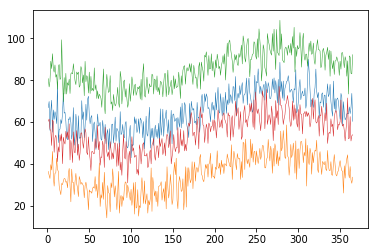

In [2]:
def toy_weather_data():
    def temp(x): return np.sin((x+365/2)*(2*np.pi)/365)*10
    def noise(state): return np.random.normal(-5, 5, sum(df['state'] == state))
    states = ['CA', 'CO', 'AZ', 'WA']
    bases = [70, 40, 90, 60]
    # np.random.choice(states, len(df))
    states_dfs = []
    for base,state in zip(bases,states):
        df = pd.DataFrame()
        df['dayofyear'] = range(1,365+1)
        df['state'] = state
        df['temperature'] = temp(df['dayofyear']) + base + noise(state)
        states_dfs.append(df)

    return pd.concat(states_dfs, axis=0)

df = toy_weather_data()

avgtmp = df.groupby(['state','dayofyear'])[['temperature']].mean()
# avgtmp.sort_values('dayofyear')
avgtmp = avgtmp.reset_index()
ca = avgtmp.query('state=="CA"')
co = avgtmp.query('state=="CO"')
az = avgtmp.query('state=="AZ"')
wa = avgtmp.query('state=="WA"')

fig, ax = plt.subplots(1,1)
ax.plot(ca['dayofyear'], ca['temperature'], label="CA", lw=.5)
ax.plot(co['dayofyear'], co['temperature'], label="CO", lw=.5)
ax.plot(az['dayofyear'], az['temperature'], label="AZ", lw=.5)
ax.plot(wa['dayofyear'], wa['temperature'], label="WA", lw=.5)

plt.show()

In [37]:
df = pd.read_feather("/Users/parrt/github/mlbook-private/data/bulldozer-train.feather")
df.head(10)

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1646770,9500,1126363,8434,132,18.0,1974,NaN,None,1989-01-17,...,None,None,None,None,None,None or Unspecified,Straight,None or Unspecified,None,None
1,1404019,24000,1169900,7110,132,99.0,1986,NaN,None,1989-01-31,...,None,None,None,None,None,None,None,None,None,None
2,1415646,35000,1262088,3357,132,99.0,1975,NaN,None,1989-01-31,...,None,None,None,None,None,None,None,None,None,None
3,1596358,19000,1433229,8247,132,99.0,1978,NaN,None,1989-01-31,...,None,None,None,None,None,None,None,None,Standard,Conventional
4,1821514,14000,1194089,10150,132,99.0,1980,NaN,None,1989-01-31,...,None,None,None,None,None,None,None,None,Standard,Conventional
5,1363540,22500,1413842,7267,132,99.0,1976,NaN,None,1989-01-31,...,None,None,None,None,None,None,None,None,Standard,Conventional
6,1379228,31000,1082797,7620,132,99.0,1986,NaN,None,1989-01-31,...,None,None,None,None,None,None,None,None,Standard,Conventional
7,1491298,46000,1322436,4107,132,99.0,1987,NaN,None,1989-01-31,...,None,None,None,None,None,None or Unspecified,PAT,None or Unspecified,None,None
8,1305337,17000,1517075,3356,132,99.0,1972,NaN,None,1989-01-31,...,None,None,None,None,None,None,None,None,None,None
9,1305336,17000,1236263,3356,132,99.0,1972,NaN,None,1989-01-31,...,None,None,None,None,None,None,None,None,None,None


In [38]:
df['MachineHours'] = df['MachineHoursCurrentMeter'] # shorten name
basefeatures = ['ModelID', 'YearMade', 'MachineHours']

df = df[df['YearMade'] >= 1960]
df = df[df['MachineHours']>0]

df = df[basefeatures+['SalePrice']].reindex()
df = df.dropna(axis='rows') # drop any rows with nan

In [39]:
df = df.iloc[-10_000:]  # take only last 10,000 records

In [40]:
len(np.unique(df['ModelID']))

1551

In [42]:
len(df.groupby('ModelID').mean()['SalePrice'])

1551

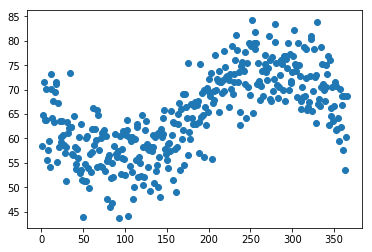

In [17]:
df = toy_weather_data()
df = df[df['state']=='CA']
X = df['dayofyear'].values#.reshape(-1,1)
y = df['temperature'].values

plt.scatter(X,y)
plt.show()

In [41]:
bins = np.linspace(0,365,num=20)
I = np.interp(bins, X, y)

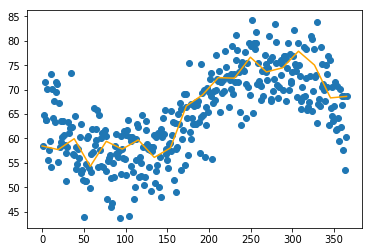

In [42]:
plt.scatter(X,y)
plt.plot(bins,I,c='orange')
plt.show()

In [39]:
I

array([58.44329653, 56.46084252, 64.79289074, 70.16520268, 68.61062441])

In [40]:
np.diff(I)

array([-1.98245401,  8.33204822,  5.37231193, -1.55457826])

In [44]:
np.digitize(X, bins)

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
       12, 12, 12, 12, 12

In [49]:
X = [1,1,1,   3,3, 4,4,4,4]
y = [10,7,11, 8,8, 1,2,3,4]
bins = np.linspace(1,4,num=4)
I = np.interp(bins, X, y)
print(bins)
print(I)

[1. 2. 3. 4.]
[11.   9.5  8.   4. ]


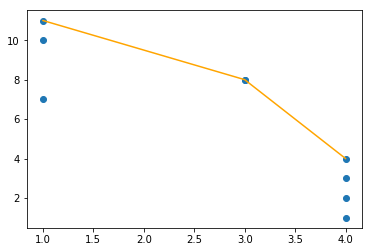

In [48]:
plt.scatter(X,y)
plt.plot(bins,I,c='orange')
plt.show()